# DATA Structure 
data/<br>
test_black: 3740 items (0.jpg -3000.jpg + image5000.jpg-image5738.jpg)<br>
test_color: 3740 items (0.jpg -3000.jpg + image5000.jpg-image5738.jpg)<br>
train_black:9128 items (3001.jpg -7128.jpg + image0000.jpg-image4999jpg)<br>
train_color: 9128 items (3001.jpg -7128.jpg + image0000.jpg-image4999jpg)<br>

#### Organize Dataset Loader in Jupyter

In [17]:
import sys
print(sys.executable)


d:\1_Charvi\COMPvISION\cv_env\Scripts\python.exe


In [18]:
!pip install pillow torchvision torch matplotlib


Unable to create process using 'C:\Users\Jishnu Nallareddy\anaconda3\python.exe "d:\1_Charvi\COMPvISION\cv_env\Scripts\pip.exe" install pillow torchvision torch matplotlib'


In [19]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class ColorizationDataset(Dataset):
    def __init__(self, black_dir, color_dir, transform_input=None, transform_target=None):
        self.black_dir = black_dir
        self.color_dir = color_dir
        self.black_images = sorted(os.listdir(black_dir))
        self.color_images = sorted(os.listdir(color_dir))
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.black_images)

    def __getitem__(self, idx):
        black_path = os.path.join(self.black_dir, self.black_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        black_image = Image.open(black_path).convert("L")  # Grayscale
        color_image = Image.open(color_path).convert("RGB")  # Color

        if self.transform_input:
            black_image = self.transform_input(black_image)
        if self.transform_target:
            color_image = self.transform_target(color_image)

        return black_image, color_image


In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform_input = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# transform_target = transforms.Compose([
#  transforms.Resize((256, 256)),
#     transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     # Normalize RGB to [-1, 1]
# ])
transform_target = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Optional
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


train_dataset = ColorizationDataset(
    black_dir='data/train_black',
    color_dir='data/train_color',
    transform_input=transform_input,
    transform_target=transform_target
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


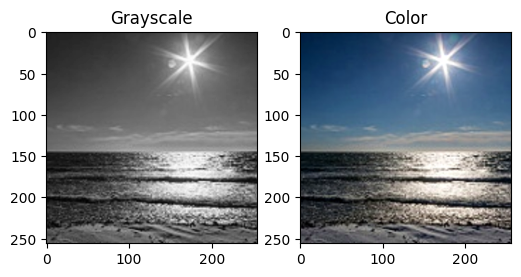

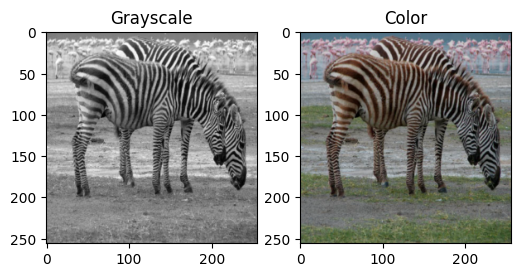

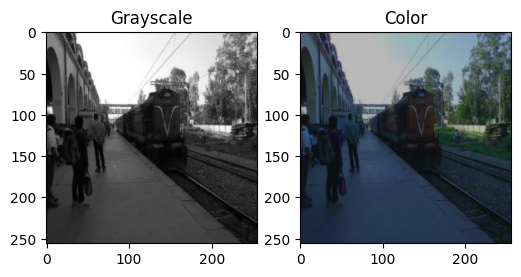

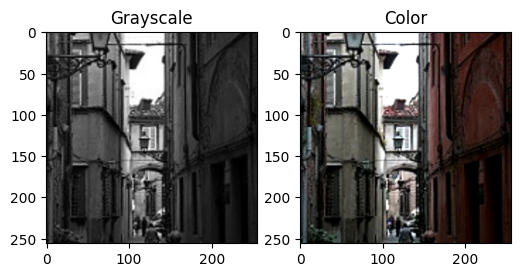

In [21]:
import matplotlib.pyplot as plt

def unnormalize(tensor):
    return torch.clamp((tensor * 0.5) + 0.5, 0, 1)


def show_sample(batch):
    gray, color = batch
    for i in range(4):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(gray[i][0], cmap='gray')
        axs[0].set_title("Grayscale")
        # axs[1].imshow(color[i].permute(1, 2, 0))
        axs[1].imshow(unnormalize(color[i]).permute(1, 2, 0))
        axs[1].set_title("Color")
        plt.show()

sample_batch = next(iter(train_loader))
show_sample(sample_batch)


We'll use a U-Net architecture

In [7]:
import torch
import torch.nn as nn

class UNetColorization(nn.Module):
    def __init__(self):
        super(UNetColorization, self).__init__()
        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

        def up(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

        self.encoder = nn.Sequential(
            down(1, 64),
            down(64, 128),
            down(128, 256),
            down(256, 512),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            up(512, 256),
            up(256, 128),
            up(128, 64),
            up(64, 32),
        )

        self.final = nn.Conv2d(32, 3, 1)  # Output 3-channel RGB

    def forward(self, x):
        enc = self.encoder(x)
        x = self.middle(enc)
        x = self.decoder(x)
        x = self.final(x)
        return torch.tanh(x)  # Output in range [-1, 1]


In [8]:
!pip install tqdm



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print(f"CUDA Version: {cuda_version}")

    # Get the GPU device name
    device_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {device_name}")
else:
    print("CUDA is not available.")


CUDA Available: True
CUDA Version: 12.1
GPU Name: NVIDIA GeForce GTX 1650


In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model (ensure you have UNetColorization defined elsewhere)
model = UNetColorization().to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate through the dataset
    for gray, color in tqdm(train_loader):  # tqdm for progress bar
        gray, color = gray.to(device), color.to(device)  # Move data to GPU

        # Forward pass
        output = model(gray)

        # Compute loss
        loss = criterion(output, color)

        # Backpropagation and optimization
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update parameters

        running_loss += loss.item()  # Accumulate loss

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Save the trained model after the final epoch
model_save_path = "unet_colorization_model.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


100%|██████████| 286/286 [06:27<00:00,  1.35s/it]


Epoch [1/10], Loss: 0.1487


100%|██████████| 286/286 [05:30<00:00,  1.15s/it]


Epoch [2/10], Loss: 0.0897


100%|██████████| 286/286 [05:57<00:00,  1.25s/it]


Epoch [3/10], Loss: 0.0855


100%|██████████| 286/286 [05:49<00:00,  1.22s/it]


Epoch [4/10], Loss: 0.0807


100%|██████████| 286/286 [04:51<00:00,  1.02s/it]


Epoch [5/10], Loss: 0.0774


100%|██████████| 286/286 [04:46<00:00,  1.00s/it]


Epoch [6/10], Loss: 0.0757


100%|██████████| 286/286 [04:32<00:00,  1.05it/s]


Epoch [7/10], Loss: 0.0774


100%|██████████| 286/286 [12:54<00:00,  2.71s/it]   


Epoch [8/10], Loss: 0.0747


100%|██████████| 286/286 [04:36<00:00,  1.04it/s]


Epoch [9/10], Loss: 0.0732


100%|██████████| 286/286 [03:41<00:00,  1.29it/s]

Epoch [10/10], Loss: 0.0720
Model saved to unet_colorization_model.pth


In [11]:
# torch.save(model.state_dict(), "colorization_unet.pth")
# Load the model
model = UNetColorization().to(device)
model.load_state_dict(torch.load("unet_colorization_model.pth"))
model.eval()  # Set the model to evaluation mode for inference


C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_15436\548370337.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_colorizati

UNetColorization(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (middle): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=

C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_15436\225793937.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_colorizat

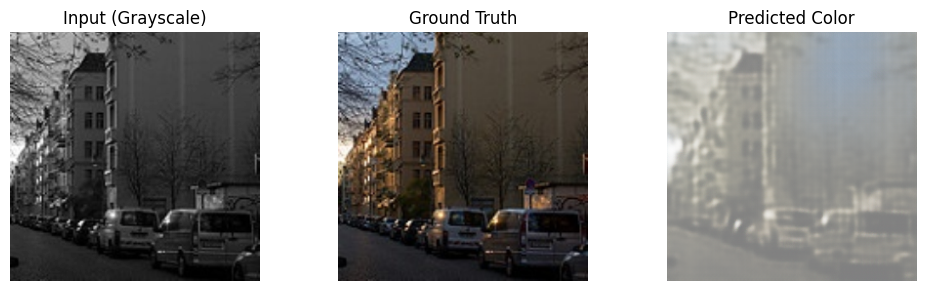

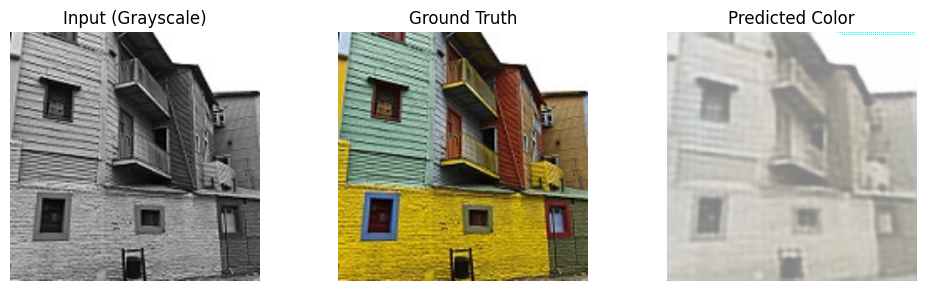

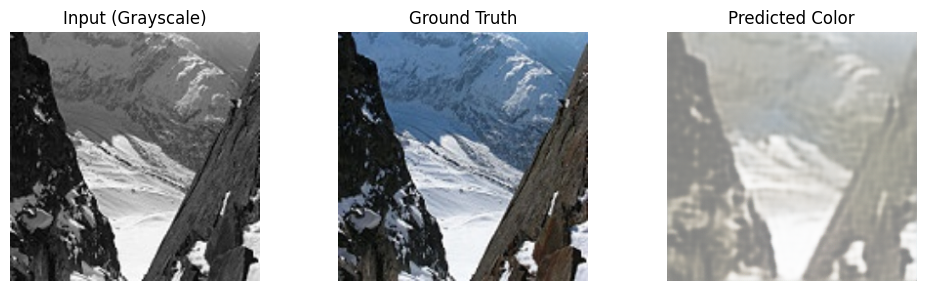

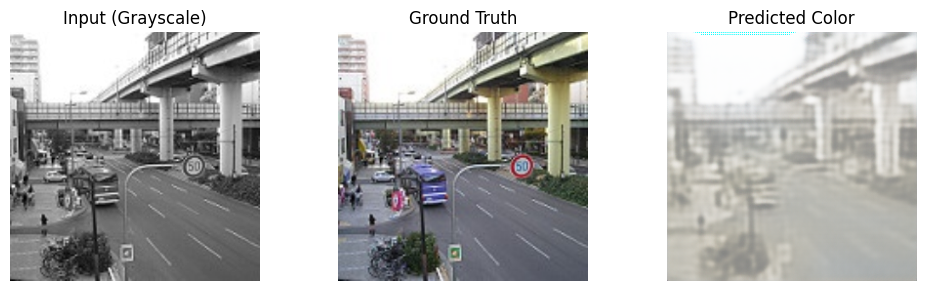

In [14]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Load test dataset
test_dataset = ColorizationDataset(
    black_dir='data/test_black',
    color_dir='data/test_color',  # We'll use this just for visual comparison
    transform_input=transform_input,
    transform_target=transform_target
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load the model
model = UNetColorization().to(device)
model.load_state_dict(torch.load("unet_colorization_model.pth", map_location=device))
model.eval()

# Visualize output
def visualize_results(model, dataloader):
    gray_batch, color_batch = next(iter(dataloader))
    gray_batch = gray_batch.to(device)

    with torch.no_grad():
        output_batch = model(gray_batch)
        output_batch = (output_batch + 1) / 2  # [-1, 1] → [0, 1]
        output_batch = torch.clamp(output_batch, 0, 1)

    for i in range(gray_batch.size(0)):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

        # Grayscale Input
        axs[0].imshow(gray_batch[i][0].cpu(), cmap='gray')
        axs[0].set_title("Input (Grayscale)")
        axs[0].axis('off')

        # Ground Truth Color
        axs[1].imshow(color_batch[i].permute(1, 2, 0).cpu())
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        # Model Output
        axs[2].imshow(output_batch[i].permute(1, 2, 0).cpu())
        axs[2].set_title("Predicted Color")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

visualize_results(model, test_loader)
